# Логистическая регрессия

Ссылка на конспект: [Logistic Regression](https://www.dmitrymakarov.ru/opt/logistic-regression-05/)

In [1]:
# помимо стандартных библиотек мы также импортируем библиотеку warnings
# она позволит скрыть предупреждения об ошибках
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# кроме того, импортируем датасеты библиотеки sklearn
from sklearn import datasets
# а также функции для расчета метрики accuracy и построения матрицы ошибок
from sklearn.metrics import accuracy_score, confusion_matrix

# построенные нами модели мы будем сравнивать с результатом
# класса LogisticRegression библиотеки sklearn
from sklearn.linear_model import LogisticRegression

# среди прочего, мы построим модели полиномиальной логистической регрессии
from sklearn.preprocessing import PolynomialFeatures

## Бинарная логистическая регрессия

### Функция логистической регрессии

#### Сигмоида

In [2]:
def h(x, thetas):
  z = np.dot(x, thetas)
  return 1.0 / (1 + np.exp(-z))

#### Вычислительная устойчивость сигмоиды

In [3]:
# при очень больших отрицательных или положительных значениях z может возникнуть переполнение памяти (overflow)
# возьмем большое отрицательное значение
z = -999
1 / (1 + np.exp(-z))

<ipython-input-3-62a8f796f3e8>:4: RuntimeWarning: overflow encountered in exp
  1 / (1 + np.exp(-z))


0.0

In [4]:
z = 999
1 / (1 + np.exp(-z))

1.0

In [5]:
z = -999
np.exp(z) / (np.exp(z) + 1)

0.0

In [6]:
def stable_sigmoid(z):
  if z >= 0:
      return 1 / (1 + np.exp(-z))
  else:
      return np.exp(z) / (np.exp(z) + 1)

In [8]:
# проверяем: ошибок нет
z = [-99999, -555, 555, 99999]
for i in z:
  print(stable_sigmoid(i))

0.0
9.258967159247676e-242
1.0
1.0


In [10]:
from scipy.special import expit
z = [-99999, -555, 555, 99999]
for i in z:
  print(expit(i))

0.0
9.258967159247676e-242
1.0
1.0


In [11]:
def h(x, thetas):
  z = np.dot(x, thetas)
  return np.array([stable_sigmoid(value) for value in z])

In [15]:
# возьмем массив наблюдений 4 х 3 с числами от 1 до 12
x = np.arange(1, 13).reshape(4, 3)
x

array([[ 1,  2,  3],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [10, 11, 12]])

In [13]:
# и вектор из трех коэффициентов
thetas = np.array([-3, 1, 1])
thetas

array([-3,  1,  1])

In [16]:
# подадим их в модель
h(x, thetas)

array([0.88079708, 0.26894142, 0.01798621, 0.00091105])

### Функция логистической ошибки

#### График

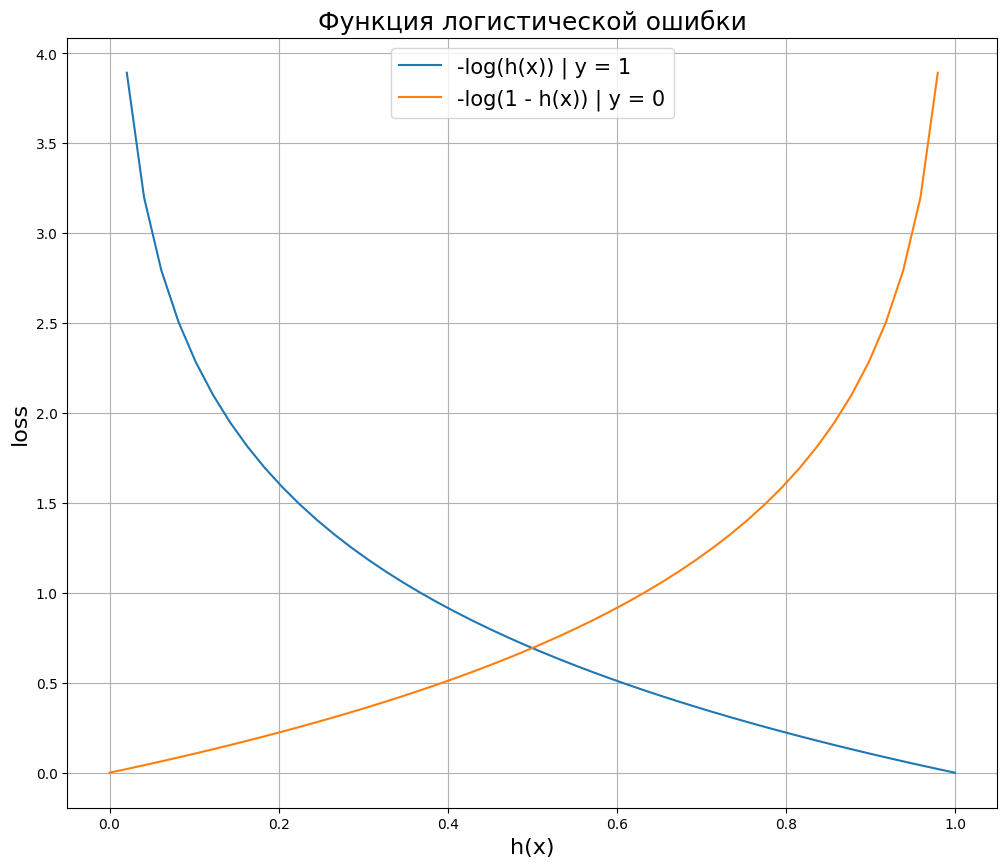

In [21]:
# уберем предупреждения о делении на ноль (нам это нужно для качественного графика)
with warnings.catch_warnings():
  warnings.simplefilter('ignore')

  plt.figure(figsize = (12, 10))

  x_vals = np.linspace(0, 1)

  plt.plot(x_vals, -np.log(x_vals), label = '-log(h(x)) | y = 1')
  plt.plot(x_vals, -np.log(1 - x_vals), label = '-log(1 - h(x)) | y = 0')
  plt.xlabel('h(x)', fontsize = 16)
  plt.ylabel('loss', fontsize = 16)
  plt.title('Функция логистической ошибки', fontsize = 18)

  plt.legend(loc = 'upper center', prop = {'size': 15})
  plt.grid()
  plt.show()

#### Простой пример

In [22]:
# предположим, мы построили модель
# выведем результат работы модели (вероятности) y_pred и целевую переменную y
output = pd.DataFrame({
    'y'        :[1, 1, 1, 0, 0, 1, 1, 0],
    'y_pred'   :[0.93, 0.81, 0.78, 0.43, 0.54, 0.49, 0.22, 0.1]
})

output

,y,y_pred
0,1,0.93
1,1,0.81
2,1,0.78
3,0,0.43
4,0,0.54
5,1,0.49
6,1,0.22
7,0,0.10


In [23]:
# найдем вероятность принадлежности к классу 1
# оставим вероятность, если y = 1, и вычтем вероятность из единицы, если y = 0
output['y=1 prob'] = np.where(output['y'] == 0, 1 - output['y_pred'], output['y_pred'])
output

,y,y_pred,y=1 prob
0,1,0.93,0.93
1,1,0.81,0.81
2,1,0.78,0.78
3,0,0.43,0.57
4,0,0.54,0.46
5,1,0.49,0.49
6,1,0.22,0.22
7,0,0.10,0.90


In [24]:
# возьмем отрицательный логарифм из каждой вероятности
output['-log'] = -np.log(output['y=1 prob'])
output

,y,y_pred,y=1 prob,-log
0,1,0.93,0.93,0.072571
1,1,0.81,0.81,0.210721
2,1,0.78,0.78,0.248461
3,0,0.43,0.57,0.562119
4,0,0.54,0.46,0.776529
5,1,0.49,0.49,0.713350
6,1,0.22,0.22,1.514128
7,0,0.10,0.90,0.105361


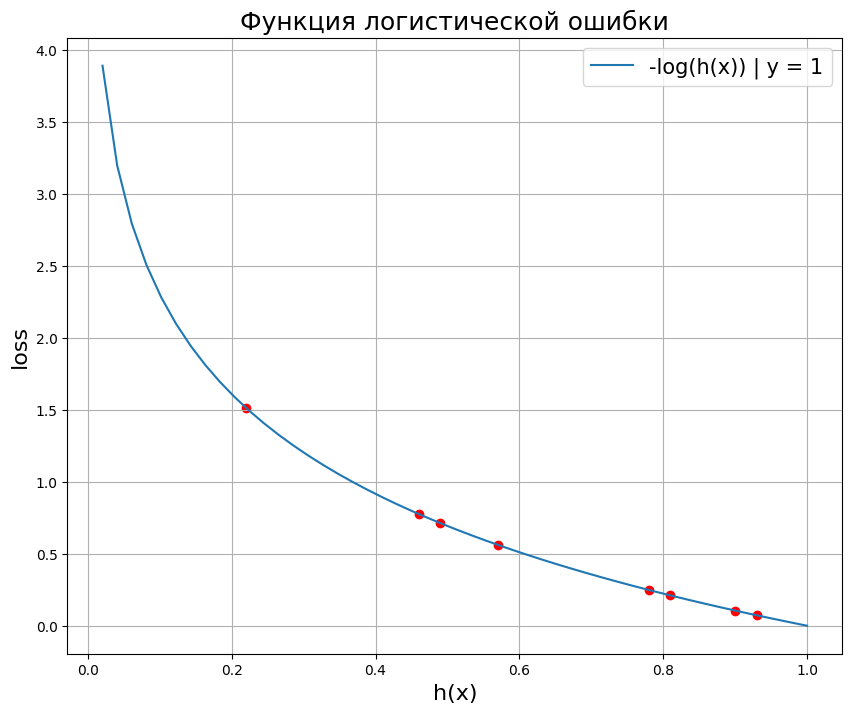

In [25]:
with warnings.catch_warnings():
  warnings.simplefilter('ignore')

  plt.figure(figsize = (10, 8))

  # создадим точки по оси x в промежутке от 0 до 1
  x_vals = np.linspace(0, 1)

  # выведем кривую функции логистической ошибки
  plt.plot(x_vals, -np.log(x_vals), label = '-log(h(x)) | y = 1')

  # выведем каждое из значений отрицательного логарифма
  plt.scatter(output['y=1 prob'], output['-log'], color = 'r')

  # зададим заголовок, подписи к осям, легенду и сетку
  plt.xlabel('h(x)', fontsize = 16)
  plt.ylabel('loss', fontsize = 16)
  plt.title('Функция логистической ошибки', fontsize = 18)
  plt.legend(loc = 'upper right', prop = {'size': 15})
  plt.grid()

  plt.show()

In [26]:
# сложим значения и разделим на количество наблюдений
output['-log'].mean()

0.525404865908324

#### Окончательный вариант

In [27]:
# напишем функцию логистической ошибки для нашего алгоритма
def objective(y, y_pred):

  # рассчитаем функцию потерь для y = 1, добавив 1e-9, чтобы избежать ошибки при log(0)
  y_one_loss = y * np.log(y_pred + 1e-9)

  # также рассчитаем функцию потерь для y = 0
  y_zero_loss = (1 - y) * np.log(1 - y_pred + 1e-9)

  # сложим и разделим на количество наблюдений
  return -np.mean(y_zero_loss + y_one_loss)

In [28]:
# проверим ее работу на учебных данных
objective(output['y'], output['y_pred'])

0.5254048640061278

### Градиент

In [37]:
# объявим градиент функции логистической ошибки
def gradient(x, y, y_pred, n):
  return np.dot(x.T, (y_pred - y)) / n

### Подготовка данных

In [38]:
# импортируем датасет о вине из модуля datasets
data = datasets.load_wine()

# превратим его в датафрейм
df = pd.DataFrame(data.data, columns = data.feature_names)

# добавим целевую переменную
df['target'] = data.target

# посмотрим на первые три строки
df.head(3)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0


#### Целевая переменная

In [39]:
# выведем размерность матрицы и уникальные значения в целевой переменной
df.shape, np.unique(df.target)

((178, 14), array([0, 1, 2]))

In [40]:
# применим маску датафрейма и удалим класс 2
df = df[df.target != 2]

# посмотрим на результат
df.shape, df.target.unique()

((130, 14), array([0, 1]))

#### Отбор признаков

Точечно-бисериальная корреляция

In [41]:
# импортируем модуль stats из библиотеки scipy
from scipy import stats

# создадим два списка, один для названий признаков, второй для корреляций
columns, correlations = [], []

# пройдемся по всем столбцам датафрейма кроме целевой переменной
for col in df.drop('target', axis = 1).columns:
  # поместим название признака в список columns
  columns.append(col)
  # рассчитаем корреляцию этого признака с целевой переменной
  # и поместим результат в список корреляций
  correlations.append(stats.pointbiserialr(df[col], df['target'])[0])

# создадим датафрейм на основе заполненных списков
# и применим градиентную цветовую схему
pd.DataFrame({'column': columns, 'correlation': correlations}).style.background_gradient()

,column,correlation
0,alcohol,-0.824399
1,malic_acid,-0.044302
2,ash,-0.354548
3,alcalinity_of_ash,0.470437
4,magnesium,-0.383085
5,total_phenols,-0.532692
6,flavanoids,-0.610730
7,nonflavanoid_phenols,0.337489
8,proanthocyanins,-0.249205
9,color_intensity,-0.750613


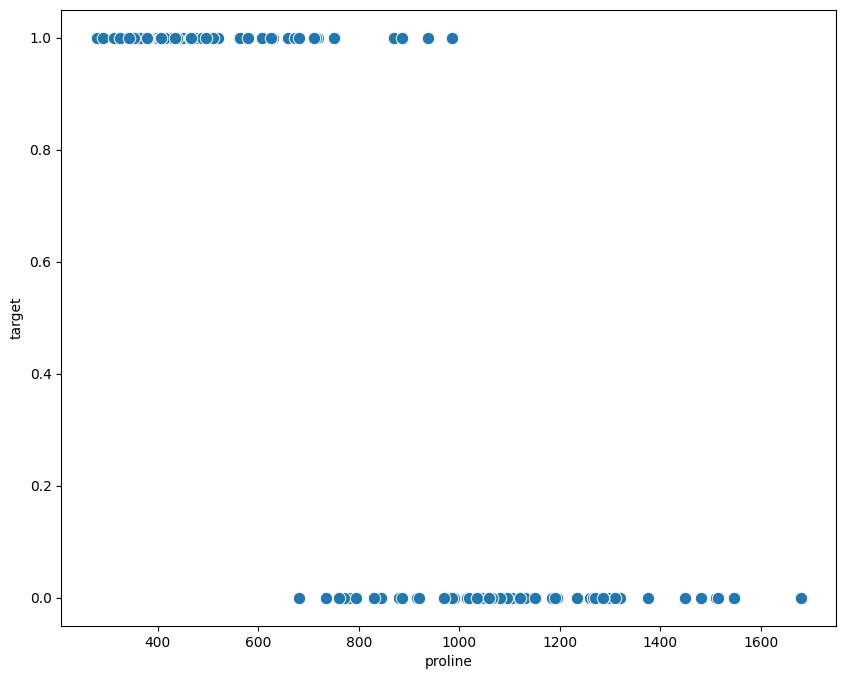

In [42]:
# зададим размер графика
plt.figure(figsize = (10, 8))
# на точечной диаграмме выведем пролин по оси x, а класс вина по оси y
sns.scatterplot(x = df.proline, y = df.target, s = 80);

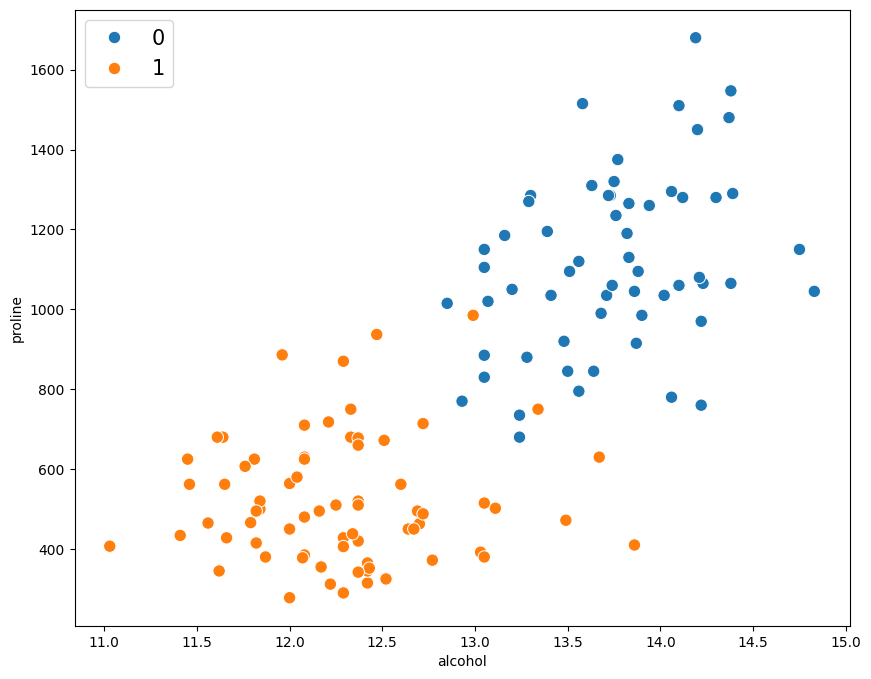

In [43]:
# зададим размер графика
plt.figure(figsize = (10, 8))
# на точечной диаграмме по осям x и y выведем признаки,
# с помощью параметра hue разделим соответствующие классы целевой переменной
sns.scatterplot(x = df.alcohol, y = df.proline, hue = df.target, s = 80)
# добавим легенду, зададим ее расположение и размер
plt.legend(loc = 'upper left', prop = {'size': 15})
# выведем результат
plt.show()

In [44]:
# поместим признаки в переменную X, а целевую переменную - в y
X = df[['alcohol', 'proline']]
y = df['target']

In [45]:
# посмотрим на количество наблюдений в каждом из классов
df.target.value_counts()

1    71
0    59
Name: target, dtype: int64

#### Масштабирование признаков

In [46]:
# выполним стандартизацию
# т.е. приведем данные к нулевому среднему и единичному СКО
X = (X - X.mean()) / X.std()
X.head()

,alcohol,proline
0,1.446858,0.779851
1,0.287952,0.737300
2,0.242946,1.120264
3,1.604379,1.957113
4,0.332958,-0.156284


In [47]:
# проверим результат
X.alcohol.mean(), X.alcohol.std(), X.proline.mean(), X.proline.std()

(6.8321416900009635e-15, 1.0, -5.465713352000771e-17, 1.0)

### Обучение модели

In [48]:
# объявим функцию, которая будет добавлять столбец под названием x0, заполненный единицами
def add_ones(x):
  # важно! метод .insert() изменяет исходный датафрейм
  return x.insert(0,'x0', np.ones(x.shape[0]))

In [49]:
# добавим столбец с единицами
add_ones(X)

# и посмотрим на результат
X.head()

,x0,alcohol,proline
0,1.0,1.446858,0.779851
1,1.0,0.287952,0.737300
2,1.0,0.242946,1.120264
3,1.0,1.604379,1.957113
4,1.0,0.332958,-0.156284


In [50]:
# создадим вектор начальных весов (он будет состоять из нулей),
# а также переменную n, в которой будет храниться количество наблюдений
thetas, n = np.zeros(X.shape[1]), X.shape[0]
thetas, n

(array([0., 0., 0.]), 130)

In [51]:
# создадим список, в который будем записывать размер ошибки функции потерь
loss_history = []

In [52]:
# в цикле из 20000 итераций
for i in range(20000):
  # рассчитаем прогнозное значение с текущими весами
  y_pred = h(X, thetas)
  # посчитаем уровень ошибки при текущем прогнозе
  loss_history.append(objective(y, y_pred))
  # рассчитаем градиент
  grad = gradient(X, y, y_pred, n)
  # используем градиент для улучшения весов модели
  # коэффициент скорости обучения будет равен 0,001
  thetas = thetas - 0.001 * grad

In [53]:
# посмотрим на получившиеся веса и финальный уровень ошибки
thetas, loss_history[-1]

(array([ 0.23234188, -1.73394252, -1.89350543]), 0.12282503517421262)

### Прогноз и оценка качества

#### Прогноз модели

In [54]:
# объявим функцию для предсказания класса
def predict(x, thetas):
  # найдем значение линейной функции
  z = np.dot(x, thetas)
  # проведем его через устойчивую сигмоиду
  probs = np.array([stable_sigmoid(value) for value in z])
  # если вероятность больше или равна 0,5 - отнесем наблюдение к классу 1,
  # в противном случае к классу 0
  # дополнительно выведем значение вероятности
  return np.where(probs >= 0.5, 1, 0), probs

In [55]:
# запишем прогноз класса и вероятность этого прогноза в переменные y_pred и probs
y_pred, probs = predict(X, thetas)

# посмотрим на прогноз и вероятность для первого наблюдения
y_pred[0], probs[0]

(0, 0.022908352078195617)

#### Метрика accuracy и матрица ошибок

In [56]:
# оценим результат с помощью метрики accuracy
accuracy_score(y, y_pred)

0.9615384615384616

In [57]:
# а также построим матрицу ошибок
# столбцами будут прогнозные значения (Forecast),
# строками - фактические (Actual)
pd.DataFrame(confusion_matrix(y, y_pred),
             columns = ['Forecast 0', 'Forecast 1'],
             index = ['Actual 0', 'Actual 1'])

,Forecast 0,Forecast 1
Actual 0,57,2
Actual 1,3,68


#### Решающая граница

In [58]:
# рассчитаем сдвиг (c) и наклон (m) линии границы
c, m = -thetas[0]/thetas[2], -thetas[1]/thetas[2]
c, m

(0.1227046263531282, -0.915731474695505)

In [59]:
# найдем минимальное и максимальное значения для спирта (ось x)
xmin, xmax = min(X['alcohol']), max(X['alcohol'])
# найдем минимальное и максимальное значения для пролина (ось y)
ymin, ymax = min(X['proline']), max(X['proline'])

# запишем значения оси x в переменную xd
xd = np.array([xmin, xmax])
xd

array([-2.15362589,  2.12194856])

In [60]:
# подставим эти значения, а также значения сдвига и наклона в уравнение линии
yd = m * xd + c

# в результате мы получим координаты двух точек, через которые проходит линия границы
(xd[0], yd[0]), (xd[1], yd[1])

((-2.1536258890738247, 2.0948476376971197),
 (2.1219485561396647, -1.8204304541886445))

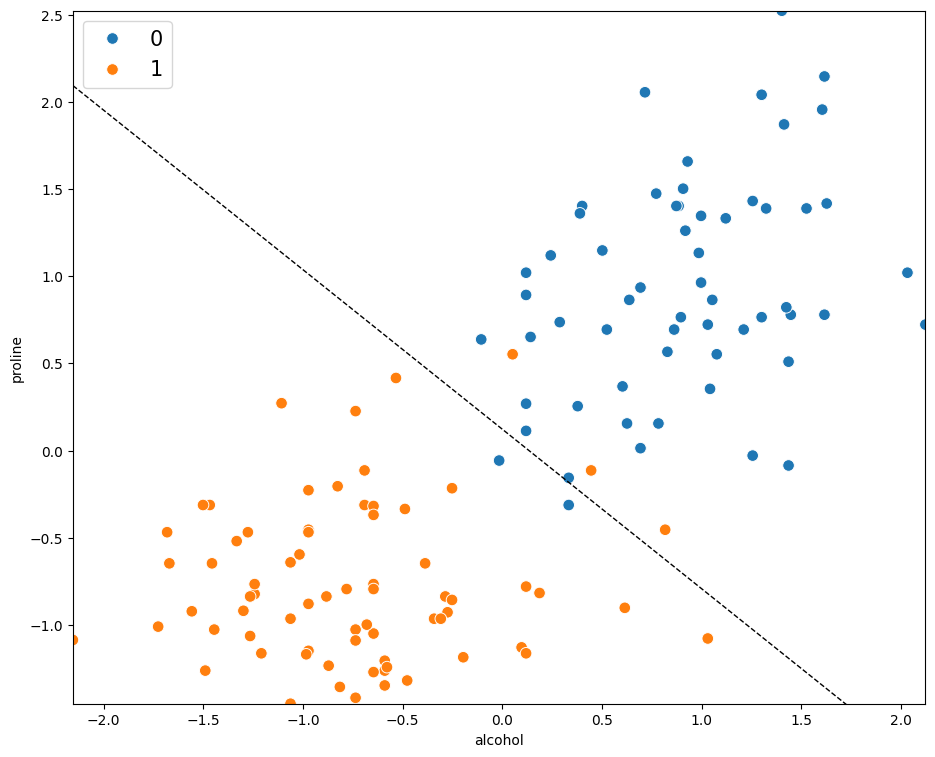

In [61]:
# зададим размер графика
plt.figure(figsize = (11, 9))

# построим пунктирную линию по двум точкам, найденным выше
plt.plot(xd, yd, 'k', lw = 1, ls = '--')

# дополнительно отобразим наши данные,
sns.scatterplot(x = X['alcohol'], y = X['proline'], hue = y, s = 70)

# которые снова снабдим легендой
plt.legend(loc = 'upper left', prop = {'size': 15})

# минимальные и максимальные значения по обеим осям будут границами графика
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# по желанию, разделенные границей половинки можно закрасить
# tab: означает, что цвета берутся из палитры Tableau
# plt.fill_between(xd, yd, ymin, color='tab:blue', alpha = 0.2)
# plt.fill_between(xd, yd, ymax, color='tab:orange', alpha = 0.2)

# а также добавить обозначения переменных в качестве подписей к осям
# plt.xlabel('x_1')
# plt.ylabel('x_2')

plt.show()

### Написание класса

In [62]:
class LogReg():

  # в методе .__init__() объявим переменные для весов и уровня ошибки
  def __init__(self):
    self.thetas = None
    self.loss_history = []

  # метод .fit() необходим для обучения модели
  # этому методу мы передадим признаки и целевую переменную
  # кроме того, мы зададим значения по умолчанию
  # для количества итераций и скорости обучения
  def fit(self, x, y, iter = 20000, learning_rate = 0.001):

    # метод создаст "правильные" копии датафрейма
    x, y = x.copy(), y.copy()

    # добавит столбец из единиц
    self.add_ones(x)

    # инициализирует веса и запишет в переменную n количество наблюдений
    thetas, n = np.zeros(x.shape[1]), x.shape[0]

    # создадим список для записи уровня ошибки
    loss_history = []

    # в цикле равном количеству итераций
    for i in range(iter):
      # метод сделает прогноз с текущими весами
      y_pred = self.h(x, thetas)
      # найдет и запишет уровень ошибки
      loss_history.append(self.objective(y, y_pred))
      # рассчитает градиент
      grad = self.gradient(x, y, y_pred, n)
      # и обновит веса
      thetas -= learning_rate * grad

      # метод выдаст веса и список с историей ошибок
      self.thetas = thetas
      self.loss_history = loss_history

  # метод .predict() делает прогноз с помощью обученной модели
  def predict(self, x):

    # метод создаст "правильную" копию модели
    x = x.copy()
    # добавит столбец из единиц
    self.add_ones(x)
    # рассчитает значения линейной функции
    z = np.dot(x, self.thetas)
    # передаст эти значения в сигмоиду
    probs = np.array([self.stable_sigmoid(value) for value in z])
    # выдаст принадлежность к определенному классу и соответствующую вероятность
    return np.where(probs >= 0.5, 1, 0), probs

  # ниже приводятся служебные методы, смысл которых был разобран ранее
  def add_ones(self, x):
    return x.insert(0,'x0', np.ones(x.shape[0]))

  def h(self, x, thetas):
    z = np.dot(x, thetas)
    return np.array([self.stable_sigmoid(value) for value in z])

  def objective(self, y, y_pred):
    y_one_loss = y * np.log(y_pred + 1e-9)
    y_zero_loss = (1 - y) * np.log(1 - y_pred + 1e-9)
    return -np.mean(y_zero_loss + y_one_loss)

  def gradient(self, x, y, y_pred, n):
    return np.dot(x.T, (y_pred - y)) / n

  def stable_sigmoid(self, z):
    if z >= 0:
        return 1 / (1 + np.exp(-z))
    else:
        return np.exp(z) / (np.exp(z) + 1)

In [63]:
# проверим работу написанного нами класса
# поместим признаки и целевую переменную в X и y
X = df[['alcohol', 'proline']]
y = df['target']

# приведем признаки к одному масштабу
X = (X - X.mean())/X.std()

# создадим объект класса LogReg
model = LogReg()

# и обучим модель
model.fit(X, y)

# посмотрим на атрибуты весов и финального уровня ошибки
model.thetas, model.loss_history[-1]

(array([ 0.23234188, -1.73394252, -1.89350543]), 0.12282503517421262)

In [64]:
# сделаем прогноз
y_pred, probs = model.predict(X)

# и посмотрим на класс первого наблюдения и вероятность
y_pred[0], probs[0]

(0, 0.022908352078195617)

In [65]:
# рассчитаем accuracy
accuracy_score(y, y_pred)

0.9615384615384616

In [66]:
# создадим матрицу ошибок
pd.DataFrame(confusion_matrix(y, y_pred),
             columns = ['Forecast 0', 'Forecast 1'],
             index = ['Actual 0', 'Actual 1'])

,Forecast 0,Forecast 1
Actual 0,57,2
Actual 1,3,68


### Сравнение с Sklearn

Обучение модели

In [67]:
# подготовим данные
X = df[['alcohol', 'proline']]
y = df['target']

X = (X - X.mean())/X.std()

# создадим объект класса LogisticRegression и запишем его в переменную model
model = LogisticRegression()

# обучим модель
model.fit(X, y)

# посмотрим на получившиеся веса модели
model.intercept_, model.coef_

(array([0.30838852]), array([[-2.09622008, -2.45991159]]))

Прогноз

In [68]:
# выполним предсказание класса
y_pred = model.predict(X)

# и найдем вероятности
probs = model.predict_proba(X)

# посмотрим на класс и вероятность первого наблюдения
y_pred[0], probs[0]

(0, array([0.9904622, 0.0095378]))

Оценка качества

In [69]:
# найдем accuracy
accuracy_score(y, y_pred)

0.9615384615384616

In [70]:
# и построим матрицу ошибок
pd.DataFrame(confusion_matrix(y, y_pred),
             columns = ['Forecast 0', 'Forecast 1'],
             index = ['Actual 0', 'Actual 1'])

,Forecast 0,Forecast 1
Actual 0,57,2
Actual 1,3,68


Решающая граница

In [71]:
# найдем сдвиг и наклон для уравнения решающей границы
c, m = -model.intercept_ / model.coef_[0][1], -model.coef_[0][0] / model.coef_[0][1]
c, m

(array([0.12536569]), -0.8521526076691504)

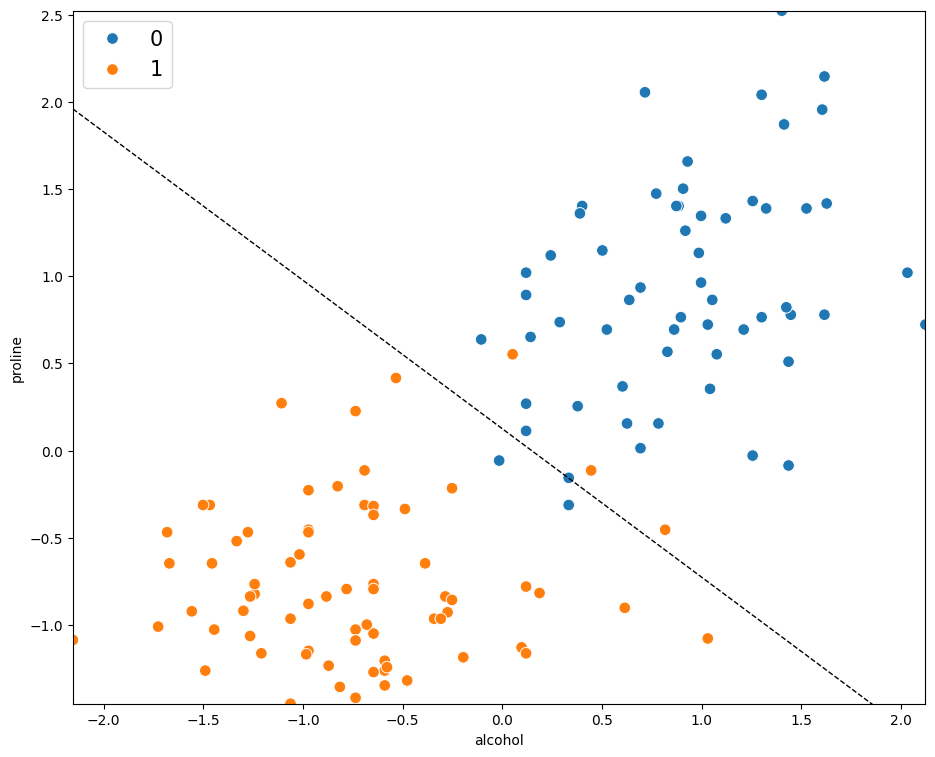

In [72]:
# посмотрим на линию решающей границы
plt.figure(figsize = (11, 9))

xmin, xmax = min(X['alcohol']), max(X['alcohol'])
ymin, ymax = min(X['proline']), max(X['proline'])
xd = np.array([xmin, xmax])
yd = m*xd + c
plt.plot(xd, yd, 'k', lw=1, ls='--')
sns.scatterplot(x = X['alcohol'], y = X['proline'], hue = y, s = 70)
plt.legend(loc = 'upper left', prop = {'size': 15})

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

plt.show()

### Бинарная полиномиальная регрессия

#### Полиномиальные признаки

In [ ]:
# подготовим и
X = df[['alcohol', 'proline']]
y = df['target']

# масштабируем данные
X = (X - X.mean())/X.std()

In [ ]:
# создадим объект класса PolynomialFeatures
# укажем, что мы хотим создать полином второй степени
polynomial_features = PolynomialFeatures(degree = 2)

# преобразуем данные с помощью метода .fit_transform()
X_poly = polynomial_features.fit_transform(X)

In [ ]:
# сравним исходные признаки
X.head(1)

,alcohol,proline
0,1.446858,0.779851


In [ ]:
# с полиномиальными
# у нас должно получиться шесть признаков (включая x0)
X_poly[:1]

array([[1.        , 1.44685785, 0.77985116, 2.09339765, 1.12833378,
        0.60816783]])

#### Моделирование и оценка качества

In [ ]:
# создадим объект класса LogisticRegression
poly_model = LogisticRegression()

# обучим модель на полиномиальных признаках
poly_model = poly_model.fit(X_poly, y)

# сделаем прогноз
y_pred = poly_model.predict(X_poly)

# рассчитаем accuracy
accuracy_score(y_pred, y)

0.9615384615384616

In [ ]:
# построим матрицу ошибок
pd.DataFrame(confusion_matrix(y, y_pred),
             columns = ['Forecast 0', 'Forecast 1'],
             index = ['Actual 0', 'Actual 1'])

,Forecast 0,Forecast 1
Actual 0,57,2
Actual 1,3,68


In [ ]:
# сделаем копию исходного датафрейма с нужными признаками
predictions = df[['alcohol', 'proline']].copy()

# и добавим новый столбец с прогнозными значениями
predictions['y_pred'] = y_pred

# посмотрим на результат
predictions.head(3)

,alcohol,proline,y_pred
0,14.23,1065.0,0
1,13.20,1050.0,0
2,13.16,1185.0,0


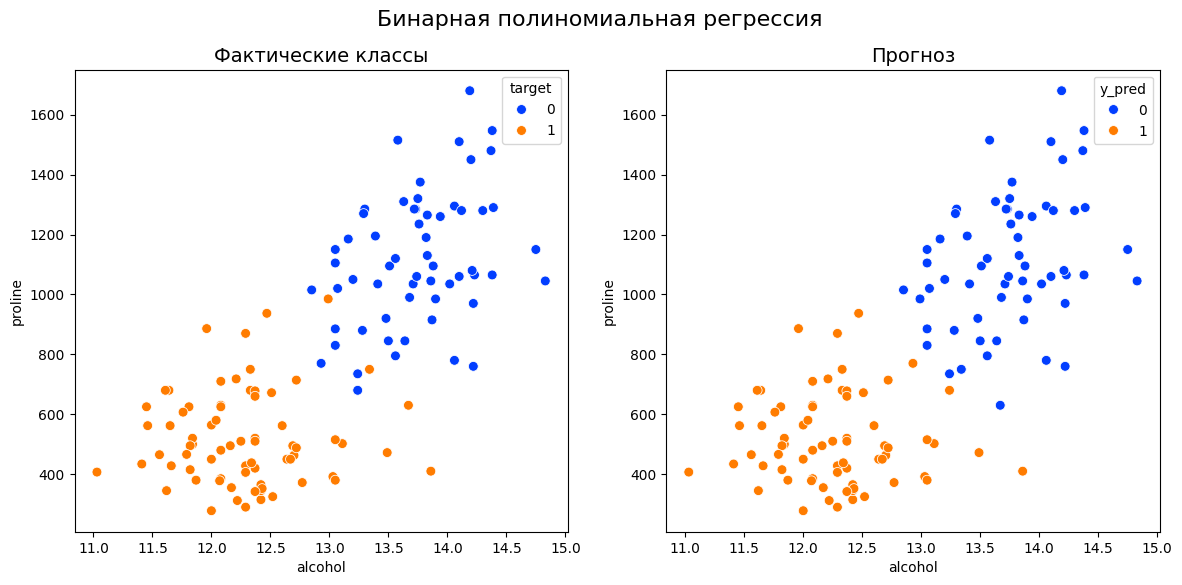

In [ ]:
# создадим два подграфика с помощью функции plt.subplots()
# расположим подграфики на одной строке
fig, (ax1, ax2) = plt.subplots(1, 2,
                               # пропишем размер,
                               figsize = (14, 6),
                               # а также расстояние между подграфиками по горизонтали
                               gridspec_kw = {'wspace' : 0.2})

# на левом подграфике выведем фактические классы
sns.scatterplot(data = df, x = 'alcohol', y = 'proline', hue = 'target', palette = 'bright', s = 50, ax = ax1)
ax1.set_title('Фактические классы', fontsize = 14)

# на правом - прогнозные
sns.scatterplot(data = predictions, x = 'alcohol', y = 'proline', hue = 'y_pred', palette = 'bright', s = 50, ax = ax2)
ax2.set_title('Прогноз', fontsize = 14)

# зададим общий заголовок
fig.suptitle('Бинарная полиномиальная регрессия', fontsize = 16)

plt.show()

## Мультиклассовая логистическая регрессия

### Подготовка данных

#### Датасет с тремя классами

In [ ]:
# вновь импортируем датасет о вине
data = datasets.load_wine()

# превратим его в датафрейм
df = pd.DataFrame(data.data, columns = data.feature_names)

# приведем признаки к одному масштабу
df = (df - df.mean())/df.std()

# добавим целевую переменную
df['target'] = data.target

# убедимся, что у нас присутствуют все три класса
df.target.value_counts()

1    71
0    59
2    48
Name: target, dtype: int64

#### Отбор признаков

In [ ]:
# код ниже был подробно разобран на предыдущем занятии
def correlation_ratio(numerical, categorical):

  values = np.array(numerical)
  ss_total = np.sum((values.mean() - values) ** 2)

  cats = np.unique(categorical, return_inverse = True)[1]

  ss_betweengroups = 0

  for c in np.unique(cats):

    group = values[np.argwhere(cats == c).flatten()]
    ss_betweengroups += len(group) * (group.mean() - values.mean()) ** 2

  return np.sqrt(ss_betweengroups/ss_total)

In [ ]:
# создадим два списка, один для названий признаков, второй для значений корреляционного отношения
columns, correlations = [], []

# пройдемся по всем столбцам датафрейма кроме целевой переменной
for col in df.drop('target', axis = 1).columns:
  # поместим название признака в список columns
  columns.append(col)
  # рассчитаем взаимосвязь этого признака с целевой переменной
  # и поместим результат в список значений корреляционного отношения
  correlations.append(correlation_ratio(df[col], df['target']))

# создадим датафрейм на основе заполненных списков
# и применим градиентную цветовую схему
pd.DataFrame({'column': columns, 'correlation': correlations}).style.background_gradient()

,column,correlation
0,alcohol,0.779024
1,malic_acid,0.544857
2,ash,0.363394
3,alcalinity_of_ash,0.538689
4,magnesium,0.352680
5,total_phenols,0.719163
6,flavanoids,0.853098
7,nonflavanoid_phenols,0.489519
8,proanthocyanins,0.506986
9,color_intensity,0.761353


In [ ]:
# оставим два признака с наибольшей корреляцией с целевой переменной
df = df[['flavanoids', 'proline', 'target']].copy()
df.head(3)

,flavanoids,proline,target
0,1.031908,1.010159,0
1,0.731565,0.962526,0
2,1.212114,1.391224,0


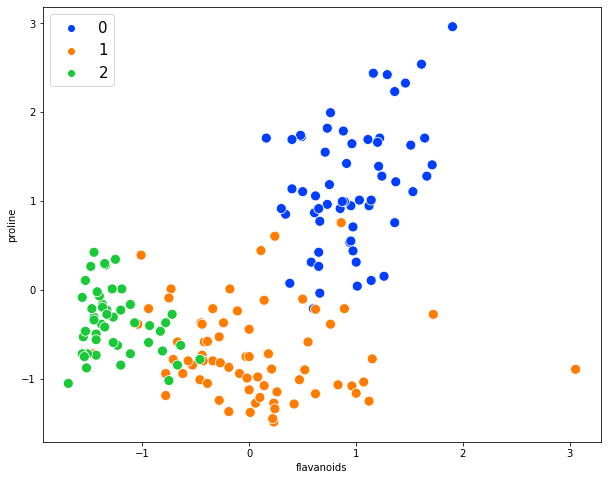

In [ ]:
# зададим размер графика
plt.figure(figsize = (10, 8))
# построим точечную диаграмму с двумя признаками, разделяющей категориальной переменной будет класс вина
sns.scatterplot(x = df.flavanoids, y = df.proline, hue = df.target, palette = 'bright', s = 100)
# добавим легенду
plt.legend(loc = 'upper left', prop = {'size': 15})
plt.show()

### Подход one-vs-rest

#### Подготовка датасетов

In [ ]:
# поместим признаки и данные в соответствующие переменные
x1, x2 = df.columns[0], df.columns[1]

target = df.target.unique()
target

array([0, 1, 2])

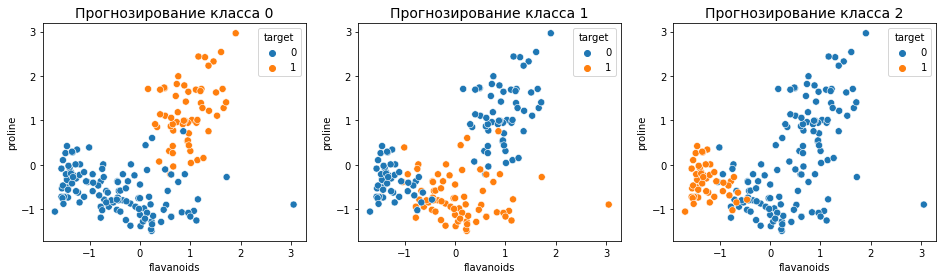

In [ ]:
# сделаем копии датафреймов
ovr_0, ovr_1, ovr_2 = df.copy(), df.copy(), df.copy()

# в каждом из них сделаем целевым классом 0-й, 1-й или 2-й классы
# например, в ovr_0 первым классом будет класс 0, а классы 1 и 2 - нулевым
ovr_0['target'] = np.where(df['target'] == target[0], 1, 0)
ovr_1['target'] = np.where(df['target'] == target[1], 1, 0)
ovr_2['target'] = np.where(df['target'] == target[2], 1, 0)

# выведем разделение на классы на графике
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,
                                    figsize = (16, 4),
                                    gridspec_kw = {'wspace': 0.2, 'hspace': 0.08})

sns.scatterplot(data = ovr_0, x = x1, y = x2, hue = 'target', s = 50, ax = ax1)
ax1.set_title('Прогнозирование класса 0', fontsize = 14)

sns.scatterplot(data = ovr_1, x = x1, y = x2, hue = 'target', s = 50, ax = ax2)
ax2.set_title('Прогнозирование класса 1', fontsize = 14)

sns.scatterplot(data = ovr_2, x = x1, y = x2, hue = 'target', s = 50, ax = ax3)
ax3.set_title('Прогнозирование класса 2', fontsize = 14)

plt.show()

In [ ]:
ovr_0.head(3)

,flavanoids,proline,target
0,1.031908,1.010159,1
1,0.731565,0.962526,1
2,1.212114,1.391224,1


#### Обучение моделей

In [ ]:
models = []

# поочередно обучим каждую из моделей
for ova_n in [ovr_0, ovr_1, ovr_2]:
  X = ova_n[['flavanoids', 'proline']]
  y = ova_n['target']

  model = LogReg()
  model.fit(X, y)

  # каждую обученную модель поместим в список
  models.append(model)

In [ ]:
# убедимся, что все работает
# например, выведем коэффициенты модели 1
models[0].thetas

array([-0.99971466,  1.280398  ,  2.04834457])

#### Прогноз и оценка качества

In [ ]:
# вновь перенесем данные из исходного датафрейма
X = df[['flavanoids', 'proline']]
y = df['target']

# в список probs будем записывать результат каждой модели
# т.е. три массива Numpy по 178 вероятностей
probs = []

for model in models:
  _, prob = model.predict(X)
  probs.append(prob)

In [ ]:
# очевидно, для каждого наблюдения у нас будет три вероятности
# принадлежности к целевому классу
probs[0][0], probs[1][0], probs[2][0]

(0.9161148288779738, 0.1540913395345091, 0.026621132600103174)

In [ ]:
# склеим внутренние и изменим размерность массива таким образом, чтобы
# строки были наблюдениями, а столбцы вероятностями
all_probs = np.concatenate(probs, axis = 0).reshape(len(probs), -1).T
all_probs.shape

(178, 3)

In [ ]:
# каждая из 178 строк - это вероятность одного наблюдения принадлежать к классу 0, 1, 2
all_probs[0]

array([0.91611483, 0.15409134, 0.02662113])

In [ ]:
# например, первое наблюдение вероятнее всего принадлежит к классу 0
np.argmax(all_probs[0])

0

In [ ]:
# найдем максимальную вероятность в каждой строке,
# индекс вероятности [0, 1, 2] и будет прогнозом
y_pred = np.argmax(all_probs, axis = 1)

# рассчитаем accuracy
accuracy_score(y, y_pred)

0.9157303370786517

In [ ]:
# выведем матрицу ошибок
pd.DataFrame(confusion_matrix(y, y_pred),
             columns = ['Forecast 0', 'Forecast 1', 'Forecast 2'],
             index = ['Actual 0', 'Actual 1', 'Actual 2'])

,Forecast 0,Forecast 1,Forecast 2
Actual 0,57,2,0
Actual 1,3,62,6
Actual 2,0,4,44


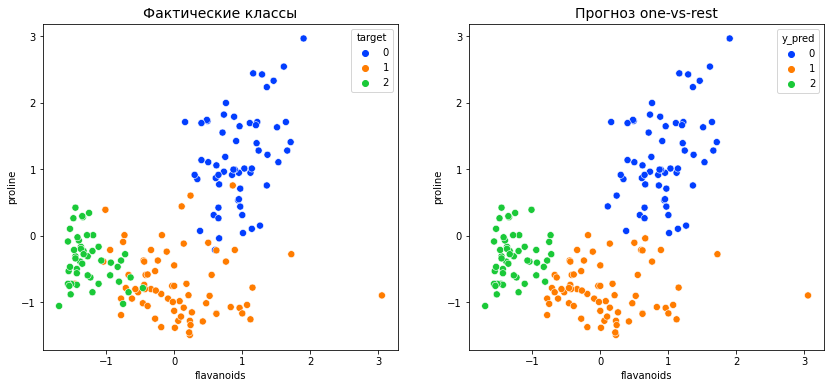

In [ ]:
predictions = df[['flavanoids', 'proline']].copy()
predictions['y_pred'] = y_pred

fig, (ax1, ax2) = plt.subplots(1, 2,
                               figsize = (14, 6),
                               gridspec_kw = {'wspace': 0.2, 'hspace': 0.08})

sns.scatterplot(data = df, x = 'flavanoids', y = 'proline', hue = 'target',
                palette = 'bright', s = 50, ax = ax1)

ax1.set_title('Фактические классы', fontsize = 14)

sns.scatterplot(data = predictions, x = 'flavanoids', y = 'proline', hue = 'y_pred',
                palette = 'bright', s = 50, ax = ax2)

ax2.set_title('Прогноз one-vs-rest', fontsize = 14)

plt.show()

#### Написание класса

In [ ]:
class OVR_LogReg():

  def __init__(self):
    self.models_thetas = []
    self.models_loss = []

  def fit(self, x, y, iter = 20000, learning_rate = 0.001):

    dfs = self.preprocess(x, y)

    models_thetas, models_loss = [], []

    for ovr_df in dfs:

      x = ovr_df.drop('target', axis = 1).copy()
      y = ovr_df.target.copy()

      self.add_ones(x)

      loss_history = []
      thetas, n = np.zeros(x.shape[1]), x.shape[0]

      for i in range(iter):
        y_pred = self.h(x, thetas)
        loss_history.append(self.objective(y, y_pred))
        grad = self.gradient(x, y, y_pred, n)
        thetas -= learning_rate * grad

      models_thetas.append(thetas)
      models_loss.append(loss_history)

    self.models_thetas = models_thetas
    self.models_loss = models_loss

  def predict(self, x):
    x = x.copy()
    probs = []
    self.add_ones(x)
    for t in self.models_thetas:
      z = np.dot(x, t)
      prob = np.array([self.stable_sigmoid(value) for value in z])
      probs.append(prob)

    all_probs = np.concatenate(probs, axis = 0).reshape(len(probs), -1).T
    y_pred = np.argmax(all_probs, axis = 1)

    return y_pred, all_probs

  def preprocess(self, x, y):

    x, y = x.copy(), y.copy()

    x['target'] = y
    classes = x.target.unique()

    dfs = []
    ovr_df = None

    for c in classes:
      ovr_df = x.drop('target', axis = 1).copy()
      ovr_df['target'] = np.where(x['target'] == classes[c], 1, 0)
      dfs.append(ovr_df)

    return dfs

  def add_ones(self, x):
    return x.insert(0,'x0', np.ones(x.shape[0]))

  def h(self, x, thetas):
    z = np.dot(x, thetas)
    return np.array([self.stable_sigmoid(value) for value in z])

  def objective(self, y, y_pred):
    y_one_loss = y * np.log(y_pred + 1e-9)
    y_zero_loss = (1 - y) * np.log(1 - y_pred + 1e-9)
    return -np.mean(y_zero_loss + y_one_loss)

  def gradient(self, x, y, y_pred, n):
    return np.dot(x.T, (y_pred - y)) / n

  def stable_sigmoid(self, z):
    if z >= 0:
        return 1 / (1 + np.exp(-z))
    else:
        return np.exp(z) / (np.exp(z) + 1)

In [ ]:
X = df[['flavanoids', 'proline']]
y = df['target']

model = OVR_LogReg()
model.fit(X, y)

y_pred, probs = model.predict(X)
accuracy_score(y_pred, y)

0.9157303370786517

#### Сравнение с sklearn

In [ ]:
X = df[['flavanoids', 'proline']]
y = df['target']

ovr_model = LogisticRegression(multi_class = 'ovr')
ovr_model = ovr_model.fit(X, y)
y_pred = ovr_model.predict(X)

accuracy_score(y_pred, y)

0.898876404494382

### Полиномиальная мультиклассовая регрессия

In [ ]:
X = df[['flavanoids', 'proline']]
y = df['target']

polynomial_features = PolynomialFeatures(degree = 7)

X_poly = polynomial_features.fit_transform(X)

poly_ovr_model = LogisticRegression(multi_class = 'ovr')
poly_ovr_model = poly_ovr_model.fit(X_poly, y)
y_pred = poly_ovr_model.predict(X_poly)

accuracy_score(y_pred, y)

0.9157303370786517

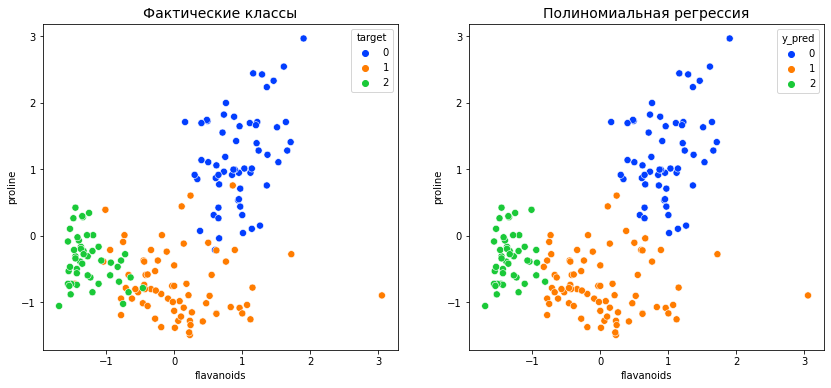

In [ ]:
predictions = df[['flavanoids', 'proline']].copy()
predictions['y_pred'] = y_pred

fig, (ax1, ax2) = plt.subplots(1, 2,
                               figsize = (14, 6),
                               gridspec_kw = {'wspace': 0.2, 'hspace': 0.08})

sns.scatterplot(data = df, x = 'flavanoids', y = 'proline', hue = 'target', palette = 'bright', s = 50, ax = ax1)
ax1.set_title('Фактические классы', fontsize = 14)

sns.scatterplot(data = predictions, x = 'flavanoids', y = 'proline', hue = 'y_pred', palette = 'bright', s = 50, ax = ax2)
ax2.set_title('Полиномиальная регрессия', fontsize = 14)

plt.show()

### Softmax Regression

#### Подготовка признаков

In [ ]:
def add_ones(x):
  # важно! метод .insert() изменяет исходный датафрейм
  return x.insert(0,'x0', np.ones(x.shape[0]))

In [ ]:
X = df[['flavanoids', 'proline']]

add_ones(X)
X.head(3)

,x0,flavanoids,proline
0,1.0,1.031908,1.010159
1,1.0,0.731565,0.962526
2,1.0,1.212114,1.391224


#### Кодирование целевой переменной

In [ ]:
def ohe(y):
  # количество примеров и количество классов
  examples, features = y.shape[0], len(np.unique(y))
  # нулевая матрица: количество наблюдений x количество признаков
  zeros_matrix = np.zeros((examples, features))
  # построчно проходимся по нулевой матрице и с помощью индекса заполняем соответствующее значение единицей
  for i, (row, digit) in enumerate(zip(zeros_matrix, y)):
    zeros_matrix[i][digit] = 1

  return zeros_matrix

In [ ]:
y = df['target']

y_enc = ohe(df['target'])
y_enc[:3]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

Класс LabelBinarizer

In [ ]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
lb.fit(y)
lb.classes_

array([0, 1, 2])

In [ ]:
y_lb = lb.transform(y)
y_lb[:5]

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

#### Инициализация весов

In [ ]:
# размерность матрицы весов:
# количество признаков х количество классов
thetas = np.zeros((3, 3))
thetas

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

#### Функция softmax

In [ ]:
X.shape, thetas.shape

((178, 3), (3, 3))

In [ ]:
z = np.dot(-X, thetas)
z.shape

(178, 3)

In [ ]:
z[:5]

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [ ]:
# axis = -1 - это последняя ось
# keepdims = True сохраняет размерность (в данном случае двумерный массив)
np.max(z, axis = -1, keepdims = True)[:5]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [ ]:
z = z - np.max(z, axis = -1, keepdims = True)
z[:5]

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [ ]:
arr = np.array([-2, 3, 0, -7, 6])
arr - max(arr)

array([ -8,  -3,  -6, -13,   0])

In [ ]:
numerator = np.exp(z)
numerator[:5]

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

In [ ]:
denominator = np.sum(numerator, axis = -1, keepdims = True)
denominator[:5]

array([[3.],
       [3.],
       [3.],
       [3.],
       [3.]])

In [ ]:
softmax = numerator / denominator
softmax[:5]

array([[0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333]])

In [ ]:
z = ([1, 2, 0.5])
np.exp(z) / sum(np.exp(z))

array([0.2312239 , 0.62853172, 0.14024438])

In [ ]:
def stable_softmax(x, thetas):
  z = np.dot(-x, thetas)
  z = z - np.max(z, axis = -1, keepdims = True)
  numerator = np.exp(z)
  denominator = np.sum(numerator, axis = -1, keepdims = True)
  softmax = numerator / denominator
  return softmax

In [ ]:
probs = stable_softmax(X, thetas)
probs[:3]

array([[0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.33333333]])

#### Функция потерь

In [ ]:
y_ohe = np.array([1, 0, 0])
softmax = np.array([0.3, 0.4, 0.4])

-np.sum(y_ohe * np.log(softmax))

1.2039728043259361

In [ ]:
y_ohe = np.array([1, 0, 0])
softmax = np.array([0.4, 0.3, 0.4])

-np.sum(y_ohe * np.log(softmax))

0.916290731874155

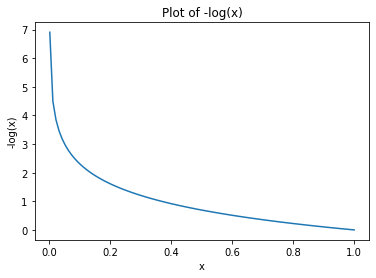

In [ ]:
x_arr = np.linspace(0.001,1, 100)
sns.lineplot(x=x_arr,y=-np.log(x_arr))
plt.title('Plot of -log(x)')
plt.xlabel('x')
plt.ylabel('-log(x)');

In [ ]:
# добавим константу в логарифм для вычислительной устойчивости
def cross_entropy(probs, y_enc, epsilon = 1e-9):
  n = probs.shape[0]
  ce = -np.sum(y_enc * np.log(probs + epsilon)) / n
  return ce

In [ ]:
ce = cross_entropy(probs, y_enc)
ce

1.0986122856681098

#### Градиент

In [ ]:
def gradient_softmax(X, probs, y_enc):
  return np.array(1 / probs.shape[0] * np.dot(X.T, (y_enc - probs)))

In [ ]:
gradient_softmax(X, probs, y_enc)

array([[-0.00187266,  0.06554307, -0.06367041],
       [ 0.31627721,  0.02059572, -0.33687293],
       [ 0.38820566, -0.28801792, -0.10018774]])

#### Обучение модели и прогноз

In [ ]:
loss_history = []

# в цикле
for i in range(30000):
  # рассчитаем прогнозное значение с текущими весами
  probs = stable_softmax(X, thetas)
  # посчитаем уровень ошибки при текущем прогнозе
  loss_history.append(cross_entropy(probs, y_enc, epsilon = 1e-9))
  # рассчитаем градиент
  grad = gradient_softmax(X, probs, y_enc)
  # используем градиент для улучшения весов модели
  thetas = thetas - 0.002 * grad

In [ ]:
thetas

array([[ 0.11290134, -0.90399727,  0.79109593],
       [-1.7550965 , -0.7857371 ,  2.5408336 ],
       [-1.93839311,  1.77140542,  0.16698769]])

In [ ]:
loss_history[0], loss_history[-1]

(1.0986122856681098, 0.2569641080523888)

In [ ]:
y_pred = np.argmax(stable_softmax(X, thetas), axis = 1)

In [ ]:
accuracy_score(y, y_pred)

0.9044943820224719

In [ ]:
pd.DataFrame(confusion_matrix(y, y_pred),
             columns = ['Forecast 0', 'Forecast 1', 'Forecast 2'],
             index = ['Actual 0', 'Actual 1', 'Actual 2'])

,Forecast 0,Forecast 1,Forecast 2
Actual 0,56,3,0
Actual 1,3,62,6
Actual 2,0,5,43


#### Написание класса

In [ ]:
class SoftmaxLogReg():

  def __init__(self):
    self.loss_ = None
    self.thetas_ = None

  def fit(self, x, y, iter = 30000, learning_rate = 0.002):

    loss_history = []

    self.add_ones(x)
    y_enc = self.ohe(y)
    thetas = np.zeros((x.shape[1], y_enc.shape[1]))

    for i in range(iter):
      probs = self.stable_softmax(x, thetas)
      loss_history.append(self.cross_entropy(probs, y_enc, epsilon = 1e-9))
      grad = self.gradient_softmax(x, probs, y_enc)
      thetas = thetas - 0.002 * grad

      self.thetas_ = thetas
      self.loss_ = loss_history

  def predict(self, x, y):
    return np.argmax(self.stable_softmax(x, thetas), axis = 1)

  def stable_softmax(self, x, thetas):
    z = np.dot(-x, thetas)
    z = z - np.max(z, axis = -1, keepdims = True)
    numerator = np.exp(z)
    denominator = np.sum(numerator, axis = -1, keepdims = True)
    softmax = numerator / denominator
    return softmax

  def cross_entropy(self, probs, y_enc, epsilon = 1e-9):
    n = probs.shape[0]
    ce = -np.sum(y_enc * np.log(probs + epsilon)) / n
    return ce

  def gradient_softmax(self, x, probs, y_enc):
    return np.array(1 / probs.shape[0] * np.dot(x.T, (y_enc - probs)))

  def add_ones(self, x):
    return x.insert(0,'x0', np.ones(x.shape[0]))

  def ohe(self, y):
    examples, features = y.shape[0], len(np.unique(y))
    zeros_matrix = np.zeros((examples, features))
    for i, (row, digit) in enumerate(zip(zeros_matrix, y)):
      zeros_matrix[i][digit] = 1

    return zeros_matrix

In [ ]:
X = df[['flavanoids', 'proline']]
y = df['target']

model = SoftmaxLogReg()

model.fit(X, y)
model.thetas_, model.loss_[-1]

(array([[ 0.11290134, -0.90399727,  0.79109593],
        [-1.7550965 , -0.7857371 ,  2.5408336 ],
        [-1.93839311,  1.77140542,  0.16698769]]), 0.2569641080523888)

In [ ]:
y_pred = model.predict(X, y)

accuracy_score(y, y_pred)

0.9044943820224719

#### Сравнение с sklearn

In [ ]:
X = df[['flavanoids', 'proline']]
y = df['target']

# создадим объект класса LogisticRegression и запишем его в переменную model
model = LogisticRegression(multi_class = 'multinomial')

# обучим нашу модель
model.fit(X, y)

# посмотрим на получившиеся веса модели
model.intercept_, model.coef_

(array([ 0.09046097,  1.12593099, -1.21639196]),
 array([[ 1.86357908,  1.89698292],
        [ 0.86696131, -1.43973164],
        [-2.73054039, -0.45725129]]))

In [ ]:
y_pred = model.predict(X)

accuracy_score(y, y_pred)

0.898876404494382